**Universidade Estadual de Campinas - Unicamp**

**Faculdade de Tecnologia - FT**

**Autor:** Ulisses Martins Dias

**Disciplina:** TT003 - Tópicos em Computação e Informática III

**Aula 11:** Monte Carlo com Jogo da Velha

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ulissesdias/tt003/blob/main/notebooks/aula11_monte_carlo_com_jogo_da_velha.ipynb)

In [4]:
!wget https://raw.githubusercontent.com/ulissesdias/tt003/main/libraries/breakthrough.py
import breakthrough as bkt

--2023-12-10 23:05:12--  https://raw.githubusercontent.com/ulissesdias/tt003/main/libraries/breakthrough.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8698 (8.5K) [text/plain]
Saving to: ‘breakthrough.py’

breakthrough.py     100%[===================>]   8.49K  --.-KB/s    in 0s      

2023-12-10 23:05:13 (62.0 MB/s) - ‘breakthrough.py’ saved [8698/8698]



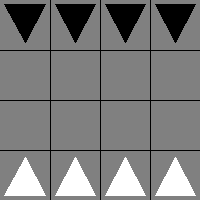

In [5]:
## Tabuleiro
lines = 4
columns = 4
white_positions = ((1,1),(1,2),(1,3),(1,4))
black_positions = ((4,1),(4,2), (4,3),(4,4))
bkt.draw_board(lines, columns, white_positions, black_positions)

In [6]:
player = bkt.random_player(lines, columns, white_positions, black_positions, 1, epsilon=5)
print(player)
# epsilon=0.5

((1, 3), (2, 2))


In [7]:
# ## Agora vamos colocar o jogador para jogar contra si mesmo.
# winner, history = bkt.game(player, player)
# winner

In [8]:
# images = bkt.generate_image_history(lines, columns, history)
# bkt.display_sequence(images)

In [9]:
def rewards(next_state) : # (turn, white, black)
    lwinner = bkt.winner(lines, columns, next_state[1], next_state[2])
    if lwinner == -1 :
        return -10
    elif lwinner == 1 :
        return 10
    elif len(next_state[2]) > len(next_state[1]):
        return -5
    elif len(next_state[1]) > len(next_state[2]):
        return 5
    else :
       return 0

In [10]:
## O código a seguir atualiza os state_values. Note que esses state_values
## são uma variável global.

def update_state_values_monte_carlo(rewards, amostra, gamma = 0.7, alpha = 0.1) :
    ## Definiremos o último state_value como zero para iniciar o processo iterativo.
    discounted_return = 0
    next_state        = amostra[-1]

    ## Observe o uso de "reversed" estamos iterando de trás pra frente.
    for state in reversed(amostra[:-1]) :
        ## Abaixo simplesmente computamos o retorno a longo prazo e somamos com a recompensa imediata
        discounted_return = gamma*discounted_return + rewards(next_state)

        ## Abaixo a fórmula para atualização dos state-values. Isso substitui o valor esperado (média).
        ## Note que estamos inicializando os state_values com zero
        state_values[state] = state_values.get(state,0) + alpha*(discounted_return - state_values.get(state, 0))
        next_state = state

In [11]:
import random

## Para computação dos state_values, usaremos gamma = 0.7 para
## descontos futuros
gamma = 0.7

## Os state_values serão uma variável global neste notebook. Nele
## estará contido tudo aquilo que o agente precisa para fazer uma boa
## jogada
state_values = {}

def player_rl(lines, columns, white_positions, black_positions, turn, epsilon = 0) :
    valid_moves = bkt.get_valid_moves(lines, columns, white_positions, black_positions, turn)

    epsilon_random = random.random()
    if epsilon_random < epsilon :
      choice = random.choice(valid_moves)
      return choice[0], choice[1]
    else :
        scores = []
        for move in valid_moves:
            white_modificavel = list(white_positions)
            black_modificavel = list(black_positions)

            if turn == 1:
                white_modificavel.remove(move[0])
                white_modificavel.append(move[1])
                if move[1] in black_modificavel:
                    black_modificavel.remove(move[1])
            else:
                black_modificavel.remove(move[0])
                black_modificavel.append(move[1])
                if move[1] in white_modificavel:
                    white_modificavel.remove(move[1])

            next_state = turn, tuple(white_modificavel), tuple(black_positions)

            ## Vejam que estamos inicializando com zero.
            scores.append(rewards(next_state) + gamma*state_values.get(tuple(next_state), 0))

        ## Analisando qual o best score de um tabuleiro.
        best_score = None
        if (turn == 1) :
            best_score = max(scores)
        else :
            best_score = min(scores)
        # print(best_score)

        ## Selecionando quais as jogadas de melhor score. Em caso de empate,
        ## escolheremos ao acaso.
        best_moves = []
        for i in range(len(scores)) :
            if scores[i] == best_score :
                best_moves.append(valid_moves[i])

        choice = random.choice(best_moves)

        ## retornando um dos melhores movimentos
        return choice[0], choice[1]

# Monte Carlo

Existe uma interseção muito grande entre o nosso conceito de episódio e o resultado já devolvido pela função **game**. O nosso jogador poderá jogar tanto com as peças brancas quanto com as peças pretas. Nesse caso, usaremos a mesma pontuação de **state_values** para ambas as situações. Se o jogador estiver jogando com as brancas, tentará maximizar.

## Atualizando Valores

## Efetuando Aprendizado

In [26]:
alpha  = 0.1 ## Aproximação da média

## Reiniciando os state_values, ou seja, o jogador não tem conhecimento prévio
state_values = {}

ITERACOES = 50000000
for i in range(ITERACOES) :
  epsilon = max(0.3, (ITERACOES - i)/ITERACOES)
  winner, history = bkt.game(player_rl, player_rl, lines, columns, white_positions, black_positions, epsilon = epsilon)
  update_state_values_monte_carlo(rewards, history, gamma, alpha)

## Validando Resultados

Vamos agora colocar o possante jogador contra alguém ao acaso.

In [27]:
def campeonato(player1, player2, num_games = 1000) :
    results = [0,0,0]
    for i in range(num_games) :
        result, x = bkt.game(player1, player2, lines, columns, white_positions, black_positions)
        results[result] += 1
    return tuple(results)

In [28]:
results = campeonato(bkt.random_player, player_rl)
print("Draw = %i, Acaso = %i, RL = %i" % results)

results = campeonato(player_rl, bkt.random_player)
print("Draw = %i, RL = %i, Acaso = %i" % results)

Draw = 0, Acaso = 487, RL = 513
Draw = 0, RL = 847, Acaso = 153


In [29]:
result, history = bkt.game(bkt.random_player, player_rl, lines, columns, white_positions, black_positions)
images = bkt.generate_image_history(lines, columns, history)
bkt.display_sequence(images)

interactive(children=(IntSlider(value=3, description='frame', max=6), Output()), _dom_classes=('widget-interac…

<function breakthrough.display_sequence.<locals>._show(frame=(0, 6))>

O jogador ficou melhor do que era antes? A distribuição de vitórias e derrotas é melhor do que o jogador ao acaso?

# Desafiando Humanos

Que tal agora desafiar um humano? Vamos gerar um código que torne isso possível, não faremos nada muito mirabolante, apenas trocaremos as chamadas de **print** para **display(board)**.


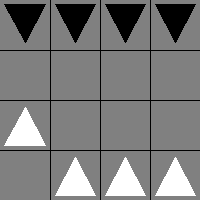

Jogue no formato '(origemLine, origemColumn), (destinoLine, destinoColumn)' 
(4, 4), (3, 4)


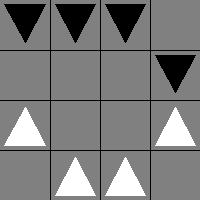

Jogue no formato '(origemLine, origemColumn), (destinoLine, destinoColumn)' 
(4, 2), (3, 2)


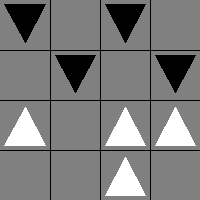

Jogue no formato '(origemLine, origemColumn), (destinoLine, destinoColumn)' 
(3, 2), (2, 3)


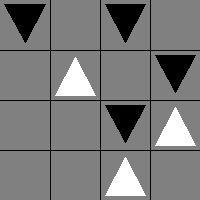

Jogue no formato '(origemLine, origemColumn), (destinoLine, destinoColumn)' 
(4, 1), (3, 1)


In [32]:
winner, history = bkt.game(player_rl, bkt.human_player, lines, columns, white_positions, black_positions)

In [33]:
images = bkt.generate_image_history(lines, columns, history)
bkt.display_sequence(images)

interactive(children=(IntSlider(value=4, description='frame', max=9), Output()), _dom_classes=('widget-interac…

<function breakthrough.display_sequence.<locals>._show(frame=(0, 9))>